In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import rasterio
from rasterio.transform import from_origin

import sys
import importlib
import os

# Add the parent directory to the system path so the notebook can find the eBird2ABAP package
sys.path.append(os.path.abspath("../"))

from eBird2ABAP import *

# Reload the module to apply changes
import eBird2ABAP

importlib.reload(eBird2ABAP)

<module 'eBird2ABAP' from '/Users/rafnuss/Library/CloudStorage/OneDrive-Vogelwarte/eBird2ABAP/eBird2ABAP/__init__.py'>

In [7]:
year = "2024"
month = "Dec"
file = f"../data/eBird/ebd_AFR_rel{month}-{year}/ebd_AFR_rel{month}-{year}.txt.gz"
ebd0 = read_EBD(file)

In [8]:
ebd = ebd0

In [ ]:
chk = (
    ebd[
        [
            "SAMPLING EVENT IDENTIFIER",
            "LATITUDE",
            "LONGITUDE",
            "OBSERVATION DATE",
            "OBSERVATION DATETIME",
            "PROTOCOL TYPE",
            "DURATION MINUTES",
            "EFFORT DISTANCE KM",
            "ALL SPECIES REPORTED",
            "OBSERVER ID",
        ]
    ]
    .drop_duplicates()
    .sort_values(by="OBSERVATION DATE")
    .reset_index()
)

sp = ebd[
[
"SAMPLING EVENT IDENTIFIER",
"LATITUDE",
"LONGITUDE",
"OBSERVATION DATE",
"OBSERVATION DATETIME",
"PROTOCOL TYPE",
"DURATION MINUTES",
"EFFORT DISTANCE KM",
"ALL SPECIES REPORTED",
"OBSERVER ID",
"SCIENTIFIC NAME",
"CATEGORY",
]
].drop_duplicates()

chk2 = (
sp[sp["CATEGORY"] == "species"]
.groupby(["SAMPLING EVENT IDENTIFIER"])
.agg(
LATITUDE=("LATITUDE", "first"),
LONGITUDE=("LONGITUDE", "first"),
OBSERVATION_DATE=("OBSERVATION DATE", "first"),
OBSERVATION_DATETIME=("OBSERVATION DATETIME", "first"),
PROTOCOL_TYPE=("PROTOCOL TYPE", "first"),
DURATION_MINUTES=("DURATION MINUTES", "first"),
EFFORT_DISTANCE_KM=("EFFORT DISTANCE KM", "first"),
ALL_SPECIES_REPORTED=("ALL SPECIES REPORTED", "first"),
OBSERVER_ID=("OBSERVER ID", "first"),
number_obs=("SCIENTIFIC NAME", "size"),
unumber_species=("SCIENTIFIC NAME", "nunique"),
)
.reset_index()
).sort_values(by="OBSERVATION_DATE")


In [10]:
chk["lat"] = chk["LATITUDE"].round(3)
chk["lon"] = chk["LONGITUDE"].round(3)
chk["month"] = chk["OBSERVATION DATE"].dt.month
chk["year"] = chk["OBSERVATION DATE"].dt.year
chk["duration_clip"] = np.clip(chk["DURATION MINUTES"], 0, 5 * 60)
chk["distance_clip"] = np.clip(chk["EFFORT DISTANCE KM"], 0, 5)

In [11]:
# Aggregate data
loc = (
    chk.groupby(["lat", "lon"])
    .agg(
        num_checklists=("SAMPLING EVENT IDENTIFIER", "count"),
        avg_duration_clip=("duration_clip", "mean"),
        avg_distance_clip=("distance_clip", "mean"),
        sum_duration=("DURATION MINUTES", "sum"),
        sum_distance=("EFFORT DISTANCE KM", "sum"),
        avg_complete=("ALL SPECIES REPORTED", "mean"),
        num_observers=("OBSERVER ID", "nunique"),
        seasonality_month=("month", "nunique"),
        seasonality_year=("year", "nunique"),
    )
    .reset_index()
)
loc["pentad"] = latlng2pentad(loc["lat"], loc["lon"])

In [11]:
loc.agg(["min", "mean", "median", "max"]).T

,min,mean,median,max
lat,-48.667,-6.916760,-5.8085,38.457
lon,-28.227,21.403230,28.0490,52.086
num_checklists,1.000,5.229727,1.0000,4150.000
avg_duration_clip,0.000,79.522685,50.0000,300.000
avg_distance_clip,0.000,3.026085,3.1640,5.000
sum_duration,0.000,390.169979,11.0000,1085317.000
sum_distance,0.000,21.511143,0.0000,64675.563
avg_complete,0.000,0.514264,0.6000,1.000
num_observers,1.000,2.943181,1.0000,2588.000
seasonality_month,1.000,1.519451,1.0000,12.000


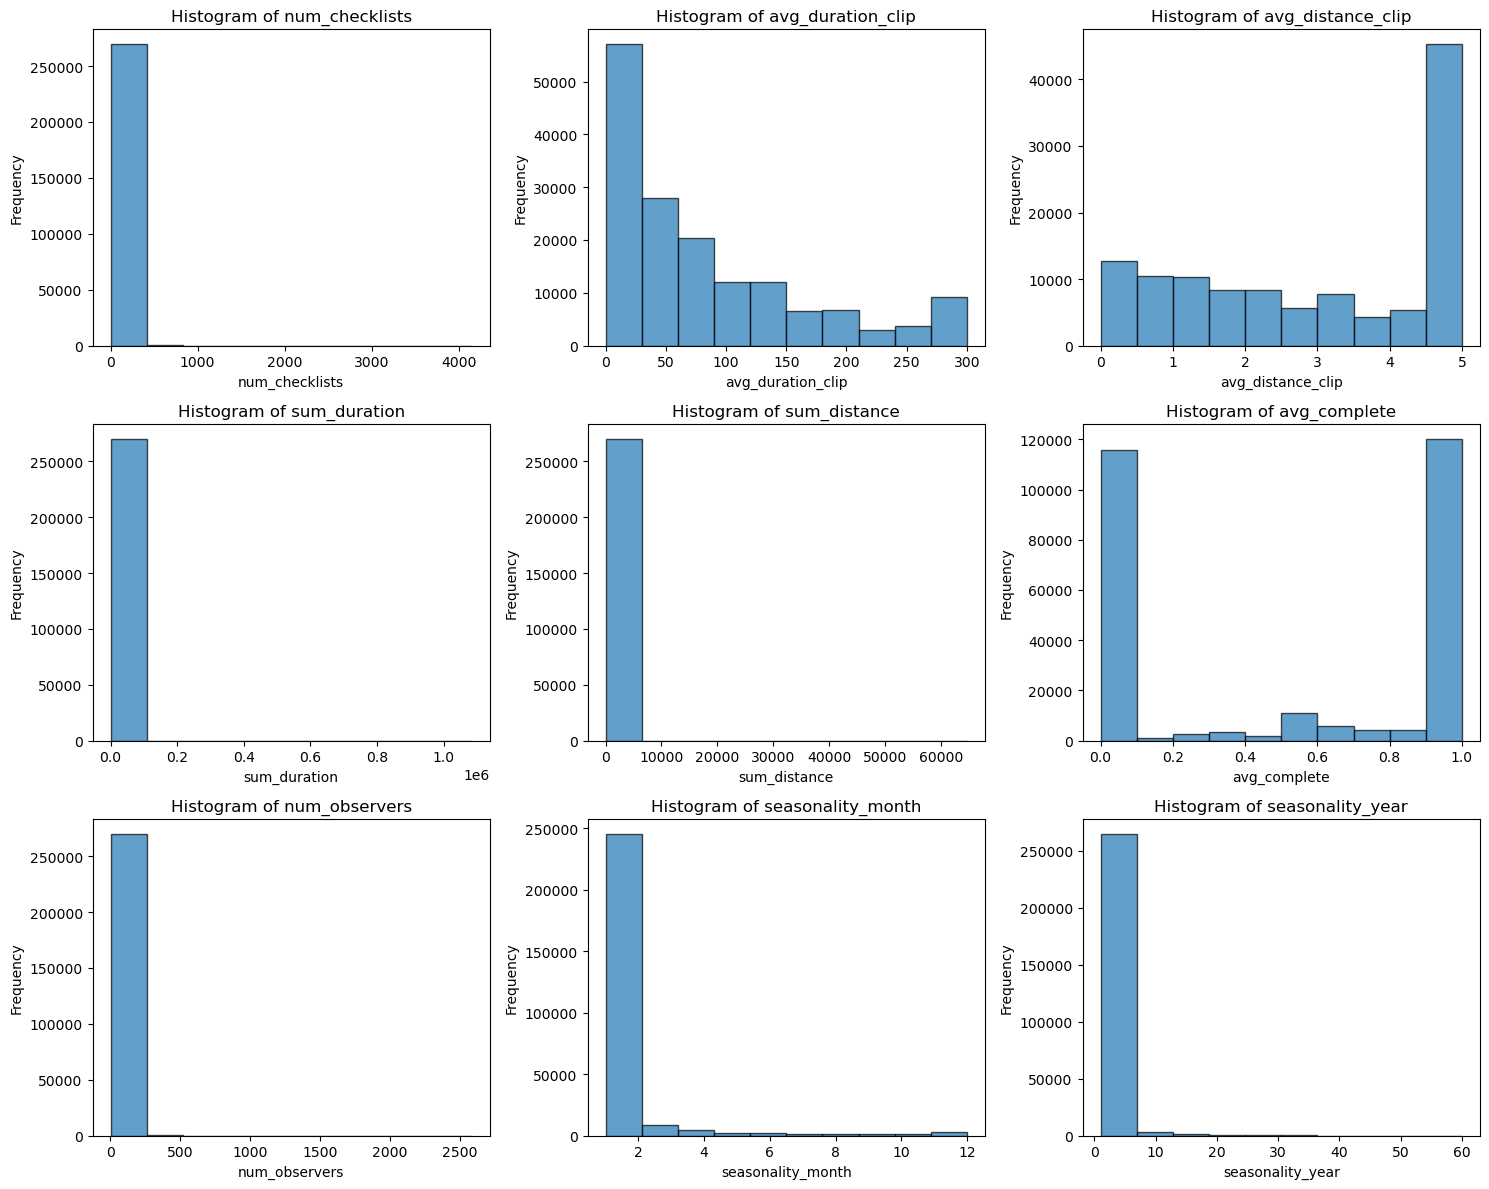

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

df = loc.iloc[:, 2:11]

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(5 * 3, 4 * 3))
axes = axes.flatten()  # Flatten in case of multiple rows

# Plot histograms
for i, col in enumerate(df.columns):
    axes[i].hist(df[col], bins=10, edgecolor="black", alpha=0.7)
    axes[i].set_title(f"Histogram of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

In [ ]:
# Option complex
loc["completeness_index"] = (
    loc["num_checklists"]
    * np.log1p(loc["mean_duration"])
    * np.log1p(loc["mean_distance"])
    * loc["avg_complete"]
    * loc["num_observers"]
    * loc["seasonality_month"]
    * loc["seasonality_year"]
)
# Option more simple
loc["completeness_index"] = loc["num_checklists"]

KeyError: 'avg_duration'

In [ ]:
loc["w"] = loc["completeness_index"]

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    loc[["w"]],
    geometry=gpd.points_from_xy(loc["lon"], loc["lat"]),
    crs="EPSG:4326",
)

# Save as GeoJSON
gdf.to_file(
    "/Users/rafnuss/Documents/GitHub/ebird-coldspot/public/ebird_loc.geojson",
    driver="GeoJSON",
)

In [ ]:
# Aggregate data
pentad = (
    # chk.groupby(["lat_group", "lon_group"])
    loc.groupby(["pentad"])
    .agg(
        num_checklists=("num_checklists", "sum"),
        sum_duration=("sum_duration", "sum"),
        sum_distance=("sum_distance", "sum"),
    )
    .reset_index()
)

pentad["lat"], pentad["lon"] = pentad2latlng(pentad["pentad"])


pentad["sum_duration"] = pentad["sum_duration"].round(0).astype(int)
pentad["sum_distance"] = pentad["sum_distance"].round(1)

In [23]:
max(pentad["num_checklists"])

9413

In [ ]:
quantiles = pentad["sum_duration"].quantile([i / 10 for i in range(11)])
print(quantiles)

0.0          0.0
0.1          0.0
0.2          0.0
0.3          5.0
0.4         37.0
0.5         90.0
0.6        185.0
0.7        398.0
0.8        948.0
0.9       3340.0
1.0    1085507.0
Name: sum_duration, dtype: float64


In [25]:
half_side = 5 / 60 / 2
from shapely.geometry import box

gdf = gpd.GeoDataFrame(
    pentad[["pentad", "sum_duration", "num_checklists"]],
    geometry=[
        box(lon - half_side, lat - half_side, lon + half_side, lat + half_side)
        for lon, lat in zip(pentad["lon"], pentad["lat"])
    ],
    crs="EPSG:4326",
)

# Save as GeoJSON
gdf.to_file(
    "/Users/rafnuss/Documents/GitHub/ebird-coldspot/public/ebird_pentad.geojson",
    driver="GeoJSON",
)

In [ ]:
# Determine the bounds of your grid (min/max latitude and longitude)
min_lat, max_lat = loc["lat_group"].min(), loc["lat_group"].max()
min_lon, max_lon = loc["lon_group"].min(), loc["lon_group"].max()

# Align the bounds to the 1/12 resolution by "snapping" to 1/12 degree
min_lat = np.floor(min_lat / grid_size) * grid_size
max_lat = np.ceil(max_lat / grid_size) * grid_size
min_lon = np.floor(min_lon / grid_size) * grid_size
max_lon = np.ceil(max_lon / grid_size) * grid_size

# Create the raster (initialize with zeros or a default value)
width = int((max_lon - min_lon) / grid_size)
height = int((max_lat - min_lat) / grid_size)

In [58]:
# Prepare the data array (you may need to fill it based on your dataset)
raster_array = np.zeros((height, width))

# Iterate through your dataset to assign values to the raster array
for _, row in loc.iterrows():
    # Calculate the indices for latitude and longitude
    lat_idx = int((row["lat_group"] - min_lat) / grid_size)
    lon_idx = int((row["lon_group"] - min_lon) / grid_size)

    # Ensure indices are within bounds (in case of exact boundary values)
    lat_idx = min(max(lat_idx, 0), height - 1)
    lon_idx = min(max(lon_idx, 0), width - 1)

    # Assign the value from your dataset to the corresponding grid cell
    raster_array[lat_idx, lon_idx] = row[
        "total_duration"
    ]  # Or another aggregation value

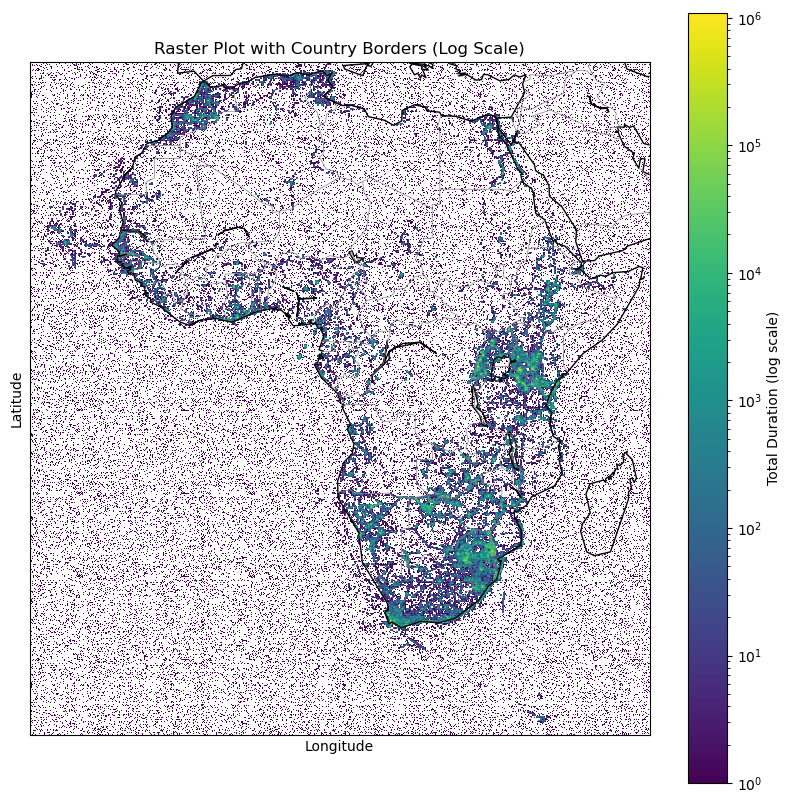

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm

# Create a Basemap instance
fig, ax = plt.subplots(figsize=(10, 10))

# Setup the map with Basemap
m = Basemap(llcrnrlat=min_lat, urcrnrlat=max_lat, llcrnrlon=min_lon, urcrnrlon=max_lon)

# Draw coastlines and country borders
m.drawcoastlines()
m.drawcountries(color="gray")

# Plot the raster on the map using imshow with a log scale
c = m.imshow(
    raster_array,
    cmap="viridis",
    origin="lower",
    norm=LogNorm(vmin=raster_array[raster_array > 0].min(), vmax=raster_array.max()),
)

# Add colorbar and labels
plt.colorbar(c, label="Total Duration (log scale)")
plt.title("Raster Plot with Country Borders (Log Scale)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the plot
plt.show()

In [ ]:
# Create the affine transform for the raster
transform = from_origin(min_lon, max_lat, grid_size, grid_size)

# Write the raster to a GeoTIFF
with rasterio.open(
    "/Users/rafnuss/Documents/GitHub/ebird-coldspot/public/ebird_loc.tiff",
    "w",
    driver="GTiff",
    height=height,
    width=width,
    count=1,
    dtype=raster_array.dtype,
    crs="EPSG:4326",
    transform=transform,
) as dst:
    dst.write(raster_array, 1)